In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as f

import fastai2 
from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

print("Pytorch:", torch.__version__)
print("Fastai2:", fastai2.__version__)
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

Pytorch: 1.5.0
Fastai2: 0.0.17
CUDA: True
GPU: GeForce GTX 1080 Ti


# Schedulers

In [22]:
1e-2

0.01

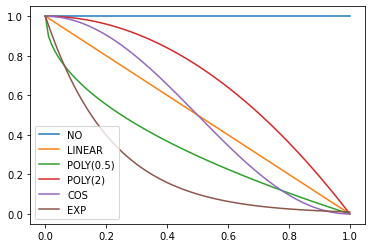

In [23]:
x = torch.linspace(0.,1,100)

scheds = [SchedNo(1,0), SchedLin(1,0), SchedPoly(1, 0, 0.5), SchedPoly(1, 0, 2), SchedCos(1, 0), SchedExp(1,0.01)]
labels = ["NO", "LINEAR", "POLY(0.5)", "POLY(2)", "COS", "EXP"]

for sched,label in zip(scheds,labels):
    plt.plot(x, [sched(val) for val in x], label=label)
plt.legend();

# Callbacks
- **`begin_fit`**: called before doing anything, ideal for initial setup.
  - **`begin_epoch`**: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch.
    - **`begin_train`**: called at the beginning of the training part of an epoch.
      - **`begin_batch`**: called at the beginning of each batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance).
        - **`after_pred`**: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss.
        - **`after_loss`**: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance).
        - **`after_backward`**: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance).
        - **`after_step`**: called after the step and before the gradients are zeroed.
      - **`after_batch`**: called at the end of a batch, for any clean-up before the next one.
    - **`after_train`**: called at the end of the training phase of an epoch.
    - **`begin_validate`**: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation.
    - **`after_validate`**: called at the end of the validation part of an epoch.
  - **`after_epoch`**: called at the end of an epoch, for any clean-up before the next one.
- **`after_fit`**: called at the end of training, for final clean-up.


When writing a callback, the following attributes of Learner are available
- **`model`**: the model used for training/validation
- **`data`**: the underlying DataLoaders
- **`loss_func`**: the loss function used
- **`opt`**: the optimizer used to udpate the model parameters
- **`opt_func`**: the function used to create the optimizer
- **`cbs`**: the list containing all Callbacks
- **`dl`**: current DataLoader used for iteration
- **`x/xb`**: last input drawn from self.dl (potentially modified by callbacks). xb is always a tuple (potentially with one element) and x is detuplified. You can only assign to xb.
- **`y/yb`**: last target drawn from self.dl (potentially modified by callbacks). yb is always a tuple (potentially with one element) and y is detuplified. You can only assign to yb.
- **`pred`**: last predictions from self.model (potentially modified by callbacks)
- **`loss`**: last computed loss (potentially modified by callbacks)
- **`n_epoch`**: the number of epochs in this training
- **`n_iter`**: the number of iterations in the current self.dl
- **`epoch`**: the current epoch index (from 0 to n_epoch-1)
- **`iter`**: the current iteration index in self.dl (from 0 to n_iter-1)

The following attributes are added by TrainEvalCallback and should be available unless you went out of your way to remove that callback
- **`train_iter`**: the number of training iterations done since the beginning of this training
- **`pct_train`**: from 0. to 1., the percentage of training iterations completed
- **`training`**: flag to indicate if we're in training mode or not

The following attribute is added by Recorder and should be available unless you went out of your way to remove that callback
- **`smooth_loss`**: an exponentially-averaged version of the training loss

In [2]:
class BatchCounter(Callback): 
    def begin_epoch(self):
        self.batch_count = 1
        return True
        
    def after_batch(self):
        self.batch_count += 1
        if self.batch_count % 200 == 0: print(f'Batch {self.batch_count} completed')
        return True
        
class TimeCheck(Callback):
    def begin_fit(self):
        self.epoch_counter = 1
        return True
    
    def begin_epoch(self):
        print(f'Epoch {self.epoch_counter} started at {time.strftime("%H:%M:%S", time.gmtime())}')
        self.epoch_counter += 1
        return True 
        
class PrintLoss(Callback):
    def after_epoch(self):
        print(f'Loss: {self.loss}')
        return True

        
class PrintIter(Callback):
    def after_batch(self):
        print("iter", self.iter, "train_iter", self.train_iter, "pct_train", self.pct_train)
        return True

### Usar los callbacks

In [ ]:
learn = Learner(dls       = ...,
                model     = ...,
                loss_func = ...,
                metrics   = ...,
                cbs       = [ShowGraphCallback(), BatchCounter(), TimeCheck(), PrintLoss()])
#learn.summary()

# Scheduler parameter callback

In [8]:
ParamScheduler

fastai2.callback.schedule.ParamScheduler

In [9]:
learn = synth_learner()

NameError: name 'synth_learner' is not defined